# FATHOM 3 pre-processing
## Flood types combination

This python notebook simply combine different rasters using a MAX criteria. Ideal for combining flood types together in a single map.

### There is no GUI. Simply edit the script, specifying the path of files that you want to combine and the output file. Run the script.


Input Raster Information:

Raster: 1in100.tif
crs: EPSG:4326
transform: | 0.00, 0.00, 13.00|
| 0.00,-0.00, 47.00|
| 0.00, 0.00, 1.00|
nodata: None
count: 1
width: 25200
height: 18000
bounds: BoundingBox(left=12.99986111111111, bottom=42.00013888888884, right=19.99986111111111, top=47.00013888888889)

Raster: 1in100.tif
crs: EPSG:4326
transform: | 0.00, 0.00, 13.00|
| 0.00,-0.00, 47.00|
| 0.00, 0.00, 1.00|
nodata: None
count: 1
width: 25200
height: 18000
bounds: BoundingBox(left=12.99986111111111, bottom=42.00013888888884, right=19.99986111111111, top=47.00013888888889)

Raster: 1in100.tif
crs: EPSG:4326
transform: | 0.00, 0.00, 13.00|
| 0.00,-0.00, 46.00|
| 0.00, 0.00, 1.00|
nodata: -32768.0
count: 1
width: 21600
height: 14400
bounds: BoundingBox(left=12.99986111111111, bottom=42.000138888888856, right=18.999861111111116, top=46.00013888888889)

Performing MAX overlay operation...
Overlay complete!

Saving result to: X:/Work/WB/Risk_tools/script/data/HZD/HRV/COMBINED/2050/SSP5_8.5/1in1

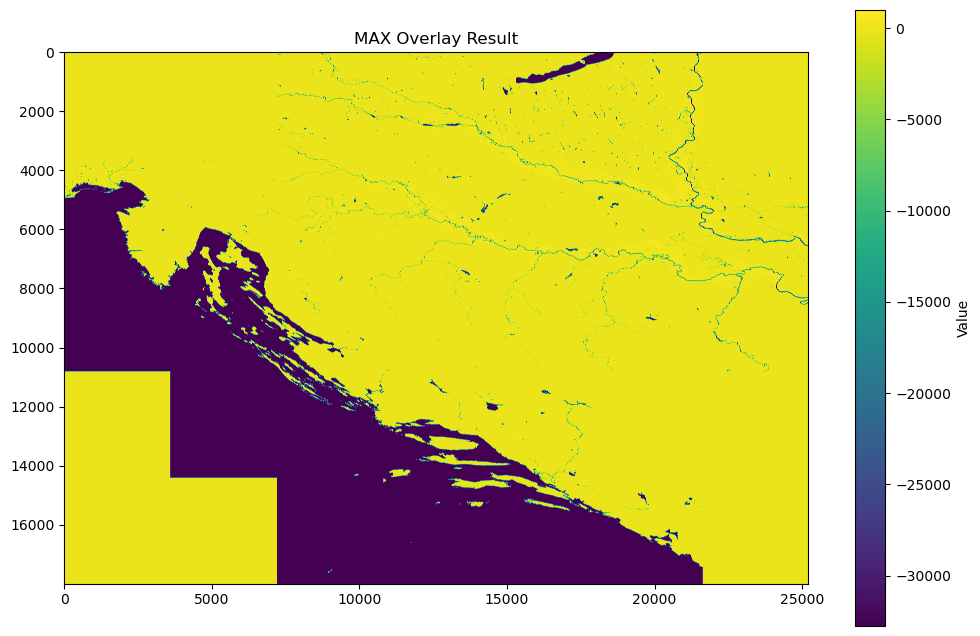


Output Raster Information:
crs: EPSG:4326
transform: | 0.00, 0.00, 13.00|
| 0.00,-0.00, 47.00|
| 0.00, 0.00, 1.00|
nodata: -9999.0
count: 1
width: 25200
height: 18000
bounds: BoundingBox(left=12.99986111111111, bottom=42.00013888888884, right=19.99986111111111, top=47.00013888888889)


In [8]:
# Import required libraries
import rasterio
import numpy as np
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from pathlib import Path
import matplotlib.pyplot as plt

# Function to read raster metadata
def get_raster_info(raster_path):
    """
    Extract key metadata from a raster file
    """
    with rasterio.open(raster_path) as src:
        return {
            'crs': src.crs,
            'transform': src.transform,
            'nodata': src.nodata,
            'count': src.count,
            'width': src.width,
            'height': src.height,
            'bounds': src.bounds
        }

# Function to calculate the union bounds of all input rasters
def calculate_union_bounds(raster_paths):
    """
    Calculate the union bounds of all input rasters
    """
    min_left = float('inf')
    min_bottom = float('inf')
    max_right = float('-inf')
    max_top = float('-inf')
    
    for path in raster_paths:
        with rasterio.open(path) as src:
            left, bottom, right, top = src.bounds
            min_left = min(min_left, left)
            min_bottom = min(min_bottom, bottom)
            max_right = max(max_right, right)
            max_top = max(max_top, top)
    
    return (min_left, min_bottom, max_right, max_top)

# Function to perform MAX overlay
def overlay_rasters_max(raster_paths):
    """
    Overlay multiple rasters using MAX criteria
    Creates a new raster that covers the union of all input extents
    """
    # Calculate the union bounds for all input rasters
    union_bounds = calculate_union_bounds(raster_paths)
    
    # Get reference metadata from the first raster
    with rasterio.open(raster_paths[0]) as src:
        ref_crs = src.crs
        ref_nodata = src.nodata if src.nodata is not None else -9999  # Set default nodata value if None
        
        # Calculate dimensions manually based on the resolution and bounds
        x_res, y_res = src.res
        dst_width = int((union_bounds[2] - union_bounds[0]) / x_res)
        dst_height = int((union_bounds[3] - union_bounds[1]) / y_res)
        
        # Calculate transform for the extent
        dst_transform = rasterio.transform.from_bounds(
            union_bounds[0], union_bounds[1], 
            union_bounds[2], union_bounds[3],
            dst_width, dst_height
        )
        
        # Create metadata for output
        dst_meta = src.meta.copy()
        dst_meta.update({
            'driver': 'GTiff',
            'height': dst_height,
            'width': dst_width,
            'transform': dst_transform,
            'nodata': ref_nodata,
            'compress': 'deflate',
            'zlevel': 9,
            'PREDICTOR': 2  # Horizontal differencing predictor for better compression
        })
        
        # Initialize output array with nodata values
        output = np.full((dst_height, dst_width), np.nan, dtype=np.float32)
    
    # Process all rasters
    for path in raster_paths:
        with rasterio.open(path) as src:
            # Initialize a destination array for this raster
            src_data = np.full((dst_height, dst_width), np.nan, dtype=np.float32)
            
            # Reproject the current raster to the union bounds
            reproject(
                source=rasterio.band(src, 1),
                destination=src_data,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=ref_crs,
                resampling=Resampling.nearest,
                src_nodata=src.nodata,
                dst_nodata=np.nan
            )
            
            # For the first raster, initialize the output
            if path == raster_paths[0]:
                output = src_data
            else:
                # Perform element-wise MAX operation
                output = np.fmax(output, src_data)
                # Handle NaN values (take the non-NaN value when one is NaN)
                mask_output_nan = np.isnan(output)
                mask_src_not_nan = ~np.isnan(src_data)
                output[mask_output_nan & mask_src_not_nan] = src_data[mask_output_nan & mask_src_not_nan]
    
    # Replace NaN with nodata value
    output = np.where(np.isnan(output), ref_nodata, output)
    
    return output, dst_meta

# Example usage
# Replace these paths with your actual raster file paths
raster_paths = [
    'X:/Work/WB/Risk_tools/script/data/HZD/HRV/FLUVIAL_UNDEFENDED/2050/SSP5_8.5/1in100.tif',
    'X:/Work/WB/Risk_tools/script/data/HZD/HRV/PLUVIAL_DEFENDED/2050/SSP5_8.5/1in100.tif',
    'X:/Work/WB/Risk_tools/script/data/HZD/HRV/COASTAL_UNDEFENDED/2050/SSP5_8.5/1in100.tif',
]

# Display input raster information
print("Input Raster Information:")
for path in raster_paths:
    print(f"\nRaster: {Path(path).name}")
    info = get_raster_info(path)
    for key, value in info.items():
        print(f"{key}: {value}")

# Perform overlay operation
print("\nPerforming MAX overlay operation...")
result, metadata = overlay_rasters_max(raster_paths)
print("Overlay complete!")

# Save the result
output_path = 'X:/Work/WB/Risk_tools/script/data/HZD/HRV/COMBINED/2050/SSP5_8.5/1in100.tif'
print(f"\nSaving result to: {output_path}")

# Write output raster
with rasterio.open(output_path, 'w', **metadata) as dst:
    dst.write(result.astype(rasterio.float32), 1)

print("Save complete!")

# Visualize results (optional)
plt.figure(figsize=(12, 8))
plt.imshow(result, cmap='viridis')
plt.colorbar(label='Value')
plt.title('MAX Overlay Result')
plt.show()

# Display output information
print("\nOutput Raster Information:")
output_info = get_raster_info(output_path)
for key, value in output_info.items():
    print(f"{key}: {value}")